In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [214]:
from sympy import (
    Derivative, 
    S, 
    Symbol, 
    series, 
    sqrt, 
    symbols, 
    oo, 
    limit, 
    Rational, 
    cos, 
    sin, 
    cosh, 
    sinh, 
    Matrix, 
    simplify, 
    latex, 
    lambdify,
    Function,
    collect,
    lambdify,
    solve,
    Eq,
    Poly,
    diff,
    nsolve,
    O,
    I,
    sqrt,
    pi,
    Add,
    latex,
    transpose
)
from sympy.core.numbers import NegativeOne, One, Zero
import numpy as np
import pandas as pd
from sympy import init_printing
init_printing() 

from sympy.printing.latex import print_latex
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook
#from pymad_hzb.PlotTools import new_plot_elems_madx
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

In [24]:
from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbFODO, 
    RsymbDrift6D, 
    RsymbQuad6D, 
    RsymbQuad6DChroma, 
    RsymbQuad6DThin
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpFODO, 
    RnpDrift6D, 
    RnpQuad6D, 
    RnpQuad6DChroma, 
    RnpQuad6DThin
)
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
    HamSQuad6D,
    HamSext6D
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket

from acchamiltoniansandmatrices.Utils.JupyterHelpFunctions import hide_toggle
from acchamiltoniansandmatrices.Utils.SymbolicFunctions import SymbolTrick, fixedpoints2D
from acchamiltoniansandmatrices.Utils.Plotting import multi_countour_plot

from acchamiltoniansandmatrices.Factorization.Factorization import truncate
from acchamiltoniansandmatrices.Tracking.LieMapTracking import AssignHam, RingHam
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList
from acchamiltoniansandmatrices.Utils.Polynomials import getpoly, RotationMatrix2D, explicitCheck, geteigenvects

In [4]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

# standardized substitutions that are useful - ORDER IN LISTS COUNTS !!!!
betagamma_rep = list(zip([beta0*gamma0,beta0],[oo,1]))
series_rep = list(zip([px,py,delta],[eps*px,eps*py,eps*delta]))
coord_rep = list(zip([x,y],[eps*x,eps*y]))
thin_rep = list(zip([px,py,delta],[0,0,0]))
xpx_rep = list(zip([y,py,delta],[0,0,0]))

In [14]:
def AssignHam(element, order=3, length=1, k=1,flag=1):
    '''
    Element:
    1 = drift space
    2 = quadrupole
    25 = skew quadrupole
    3 = sextupole
    35 = skew sextupole - tbp
    '''
    order = order +1
    betagamma_rep = list(
        zip(
            [
                beta0*gamma0,
                beta0
            ],
            [
                oo,
                1
            ]
        )
    )
    series_rep = list(
        zip(
            [
                px,
                py,
                delta
            ],
            [
                eps*px,
                eps*py,
                eps*delta
            ]
        )
    )
    coord_rep = list(zip([x,y],[eps*x,eps*y]))

    thin_rep = list(zip([px,py,delta],[0,0,0]))
    if element == 1:
        # drift hamiltonian
        H = HamDrift6D(beta0, gamma0, length,x,px,y,py,delta)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
#         H = drift(order, length)
        
    elif element == 2:
        # quadrupole - thin is set by flag
        H = NegativeOne() * Rational(1,2) * HamQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
        
#         H = quad(order, length, strength, flag)
    elif element == 25:
        H = NegativeOne() * Rational(1,2) * HamSQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
#         H = skew_quad(order, length, strength, flag)
        
    elif element == 3:
        H = NegativeOne() * Rational(1,2) * HamSext6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
#         H = sext(order, length, strength, flag)
#     elif H == 35:
#         H = skew_sext(order, length, strength)
    else:
        raise ValueError(element, ' no such reference in library.')      
    
    return H


def truncate(LieHam,degree): #cutoff Hamiltonian at specified degree
    _epstemp = symbols('e')
    fct = LieHam.ham
    
    for i in LieHam.indep_coords:
        fct = fct.subs(i,i*_epstemp)
        
    for i in LieHam.indep_mom:
        fct = fct.subs(i,i*_epstemp)
    
    fct = fct.expand()
    fct = fct + O(_epstemp**degree)
    fct = fct.removeO().subs(_epstemp,1)
    
    return fct


def RingHam(beamline,BCH_order,poly_cutoff, doit=False): #combine beamline with BCH into one map
    poly_cutoff = poly_cutoff + 1
    for i,element in enumerate(beamline):
        if i == 0:
            H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
            H_int = LieOperator(H0,[x,y,z],[px,py,delta])
        else:
            H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
            H0 = LieOperator(H0,[x,y,z],[px,py,delta])
            
            H_int = H_int.BCH(H0,BCH_order)
            
        
            H_int = H_int.doit()
    
    temp_H = truncate(H_int,poly_cutoff) #cutoff Hamiltonian at speciefied polynomial degree
    
    H = LieOperator(temp_H,[x,y,z],[px,py,delta])
    
    
    return H

def codict(expr, *x):
    collected = Poly(expr, *x).as_expr()
    return dict(i.as_independent(*x)[::-1] for i in Add.make_args(collected))

# FODO: Symoblic 

## Defintions

In [6]:
# redefine for use in ringham - otherwise assumption errors
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")
dld   = symbols('\delta{L_D}') # delta length drift

In [7]:
thin = 1
bchorder = 2
polyorder = 4

eldict = {
    'drift' : 1,
    'quad'  : 2,
    'squad' : 25,
    'sext'  : 3
}

beamline = [
    [eldict['quad'] , 2, LQF, KQF, thin],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 2, LQD, KQD, thin],
    [eldict['drift'], 4, LD + dld,   Zero(), 0   ],
    [eldict['quad'] , 2, LQF, KQF, thin],
]

## Calculate effective Hamiltonian BCH order 2

In [8]:
# Ringham but step for step to analyze the steps
element = beamline[0]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
H_int = LieOperator(H0,[x,y,z],[px,py,delta])

element = beamline[1]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
H0 = LieOperator(H0,[x,y,z],[px,py,delta])
H_int = H_int.BCH(H0,bchorder)

element = beamline[2]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
H0 = LieOperator(H0,[x,y,z],[px,py,delta])
H_int = H_int.BCH(H0,bchorder).doit()

element = beamline[3]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
H0 = LieOperator(H0,[x,y,z],[px,py,delta])
H_int = H_int.BCH(H0,bchorder).doit()

element = beamline[4]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
H0 = LieOperator(H0,[x,y,z],[px,py,delta])
H_int = H_int.BCH(H0,bchorder).doit()

In [10]:
# full expression
Hring = H_int.ham.expand()

$$
- \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta^{4} x^{2}}{64} + \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta^{4} y^{2}}{64} + \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta^{3} x^{2}}{32} - \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta^{3} y^{2}}{32} - \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta^{2} p_{x}^{2} x^{2}}{32} + \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta^{2} p_{y}^{2} y^{2}}{32} - \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta^{2} x^{2}}{64} + \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta^{2} y^{2}}{64} + \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta p_{x}^{2} x^{2}}{32} - \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta p_{y}^{2} y^{2}}{32} + \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta x^{2}}{32} - \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} \delta y^{2}}{32} - \frac{15 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{x}^{4} x^{2}}{256} - \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{x}^{4} y^{2}}{256} + \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{x}^{3} p_{y} x y}{32} - \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{x}^{2} p_{y}^{2} x^{2}}{128} + \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{x}^{2} p_{y}^{2} y^{2}}{128} - \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{x}^{2} x^{2}}{32} - \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{x} p_{y}^{3} x y}{32} + \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{y}^{4} x^{2}}{256} + \frac{15 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{y}^{4} y^{2}}{256} + \frac{3 K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} p_{y}^{2} y^{2}}{32} - \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} x^{2}}{64} + \frac{K_{QD} K_{QF}^{2} L_{D}^{2} L_{QD} L_{QF}^{2} y^{2}}{64} - \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta^{4} x^{2}}{64} + \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta^{4} y^{2}}{64} + \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta^{3} x^{2}}{32} - \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta^{3} y^{2}}{32} - \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta^{2} p_{x}^{2} x^{2}}{32} + \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta^{2} p_{y}^{2} y^{2}}{32} - \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta^{2} x^{2}}{64} + \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta^{2} y^{2}}{64} + \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta p_{x}^{2} x^{2}}{32} - \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta p_{y}^{2} y^{2}}{32} + \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta x^{2}}{32} - \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} \delta y^{2}}{32} - \frac{15 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{x}^{4} x^{2}}{256} - \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{x}^{4} y^{2}}{256} + \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{x}^{3} p_{y} x y}{32} - \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{x}^{2} p_{y}^{2} x^{2}}{128} + \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{x}^{2} p_{y}^{2} y^{2}}{128} - \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{x}^{2} x^{2}}{32} - \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{x} p_{y}^{3} x y}{32} + \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{y}^{4} x^{2}}{256} + \frac{15 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{y}^{4} y^{2}}{256} + \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} p_{y}^{2} y^{2}}{32} - \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} x^{2}}{64} + \frac{K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} \delta{L_D} y^{2}}{64} - \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} p_{x} x^{3}}{64} - \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} p_{x} x y^{2}}{64} + \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} p_{y} x^{2} y}{64} + \frac{3 K_{QD} K_{QF}^{2} L_{D} L_{QD} L_{QF}^{2} p_{y} y^{3}}{64} - \frac{K_{QD} K_{QF} L_{D} L_{QD} L_{QF} \delta^{2} x^{2}}{16} - \frac{K_{QD} K_{QF} L_{D} L_{QD} L_{QF} \delta^{2} y^{2}}{16} + \frac{K_{QD} K_{QF} L_{D} L_{QD} L_{QF} \delta x^{2}}{16} + \frac{K_{QD} K_{QF} L_{D} L_{QD} L_{QF} \delta y^{2}}{16} - \frac{3 K_{QD} K_{QF} L_{D} L_{QD} L_{QF} p_{x}^{2} x^{2}}{32} - \frac{K_{QD} K_{QF} L_{D} L_{QD} L_{QF} p_{x}^{2} y^{2}}{32} + \frac{K_{QD} K_{QF} L_{D} L_{QD} L_{QF} p_{x} p_{y} x y}{8} - \frac{K_{QD} K_{QF} L_{D} L_{QD} L_{QF} p_{y}^{2} x^{2}}{32} - \frac{3 K_{QD} K_{QF} L_{D} L_{QD} L_{QF} p_{y}^{2} y^{2}}{32} - \frac{K_{QD} K_{QF} L_{D} L_{QD} L_{QF} x^{2}}{16} - \frac{K_{QD} K_{QF} L_{D} L_{QD} L_{QF} y^{2}}{16} - \frac{K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} \delta^{2} x^{2}}{16} - \frac{K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} \delta^{2} y^{2}}{16} + \frac{K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} \delta x^{2}}{16} + \frac{K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} \delta y^{2}}{16} - \frac{3 K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} p_{x}^{2} x^{2}}{32} - \frac{K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} p_{x}^{2} y^{2}}{32} + \frac{K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} p_{x} p_{y} x y}{8} - \frac{K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} p_{y}^{2} x^{2}}{32} - \frac{3 K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} p_{y}^{2} y^{2}}{32} - \frac{K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} x^{2}}{16} - \frac{K_{QD} K_{QF} L_{QD} L_{QF} \delta{L_D} y^{2}}{16} + \frac{K_{QD} L_{D}^{2} L_{QD} \delta^{4} p_{x}^{2}}{8} - \frac{K_{QD} L_{D}^{2} L_{QD} \delta^{4} p_{y}^{2}}{8} - \frac{K_{QD} L_{D}^{2} L_{QD} \delta^{3} p_{x}^{2}}{4} + \frac{K_{QD} L_{D}^{2} L_{QD} \delta^{3} p_{y}^{2}}{4} + \frac{K_{QD} L_{D}^{2} L_{QD} \delta^{2} p_{x}^{4}}{8} + \frac{3 K_{QD} L_{D}^{2} L_{QD} \delta^{2} p_{x}^{2}}{8} - \frac{K_{QD} L_{D}^{2} L_{QD} \delta^{2} p_{y}^{4}}{8} - \frac{3 K_{QD} L_{D}^{2} L_{QD} \delta^{2} p_{y}^{2}}{8} - \frac{K_{QD} L_{D}^{2} L_{QD} \delta p_{x}^{4}}{8} - \frac{K_{QD} L_{D}^{2} L_{QD} \delta p_{x}^{2}}{4} + \frac{K_{QD} L_{D}^{2} L_{QD} \delta p_{y}^{4}}{8} + \frac{K_{QD} L_{D}^{2} L_{QD} \delta p_{y}^{2}}{4} + \frac{K_{QD} L_{D}^{2} L_{QD} p_{x}^{6}}{32} + \frac{K_{QD} L_{D}^{2} L_{QD} p_{x}^{4} p_{y}^{2}}{32} + \frac{K_{QD} L_{D}^{2} L_{QD} p_{x}^{4}}{8} - \frac{K_{QD} L_{D}^{2} L_{QD} p_{x}^{2} p_{y}^{4}}{32} + \frac{K_{QD} L_{D}^{2} L_{QD} p_{x}^{2}}{8} - \frac{K_{QD} L_{D}^{2} L_{QD} p_{y}^{6}}{32} - \frac{K_{QD} L_{D}^{2} L_{QD} p_{y}^{4}}{8} - \frac{K_{QD} L_{D}^{2} L_{QD} p_{y}^{2}}{8} + \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta^{4} p_{x}^{2}}{8} - \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta^{4} p_{y}^{2}}{8} - \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta^{3} p_{x}^{2}}{4} + \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta^{3} p_{y}^{2}}{4} + \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta^{2} p_{x}^{4}}{8} + \frac{3 K_{QD} L_{D} L_{QD} \delta{L_D} \delta^{2} p_{x}^{2}}{8} - \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta^{2} p_{y}^{4}}{8} - \frac{3 K_{QD} L_{D} L_{QD} \delta{L_D} \delta^{2} p_{y}^{2}}{8} - \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta p_{x}^{4}}{8} - \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta p_{x}^{2}}{4} + \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta p_{y}^{4}}{8} + \frac{K_{QD} L_{D} L_{QD} \delta{L_D} \delta p_{y}^{2}}{4} + \frac{K_{QD} L_{D} L_{QD} \delta{L_D} p_{x}^{6}}{32} + \frac{K_{QD} L_{D} L_{QD} \delta{L_D} p_{x}^{4} p_{y}^{2}}{32} + \frac{K_{QD} L_{D} L_{QD} \delta{L_D} p_{x}^{4}}{8} - \frac{K_{QD} L_{D} L_{QD} \delta{L_D} p_{x}^{2} p_{y}^{4}}{32} + \frac{K_{QD} L_{D} L_{QD} \delta{L_D} p_{x}^{2}}{8} - \frac{K_{QD} L_{D} L_{QD} \delta{L_D} p_{y}^{6}}{32} - \frac{K_{QD} L_{D} L_{QD} \delta{L_D} p_{y}^{4}}{8} - \frac{K_{QD} L_{D} L_{QD} \delta{L_D} p_{y}^{2}}{8} - \frac{K_{QD} L_{QD} \delta{L_D} \delta^{2} p_{x} x}{4} + \frac{K_{QD} L_{QD} \delta{L_D} \delta^{2} p_{y} y}{4} + \frac{K_{QD} L_{QD} \delta{L_D} \delta p_{x} x}{4} - \frac{K_{QD} L_{QD} \delta{L_D} \delta p_{y} y}{4} - \frac{K_{QD} L_{QD} \delta{L_D} p_{x}^{3} x}{8} + \frac{K_{QD} L_{QD} \delta{L_D} p_{x}^{2} p_{y} y}{8} - \frac{K_{QD} L_{QD} \delta{L_D} p_{x} p_{y}^{2} x}{8} - \frac{K_{QD} L_{QD} \delta{L_D} p_{x} x}{4} + \frac{K_{QD} L_{QD} \delta{L_D} p_{y}^{3} y}{8} + \frac{K_{QD} L_{QD} \delta{L_D} p_{y} y}{4} - \frac{K_{QD} L_{QD} x^{2}}{4} + \frac{K_{QD} L_{QD} y^{2}}{4} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta^{4} p_{x} x}{16} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta^{4} p_{y} y}{16} + \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta^{3} p_{x} x}{8} + \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta^{3} p_{y} y}{8} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta^{2} p_{x}^{3} x}{8} - \frac{3 K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta^{2} p_{x} x}{16} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta^{2} p_{y}^{3} y}{8} - \frac{3 K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta^{2} p_{y} y}{16} + \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta p_{x}^{3} x}{8} + \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta p_{x} x}{8} + \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta p_{y}^{3} y}{8} + \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} \delta p_{y} y}{8} - \frac{3 K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{x}^{5} x}{64} + \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{x}^{4} p_{y} y}{64} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{x}^{3} p_{y}^{2} x}{32} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{x}^{3} x}{8} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{x}^{2} p_{y}^{3} y}{32} + \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{x} p_{y}^{4} x}{64} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{x} x}{16} - \frac{3 K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{y}^{5} y}{64} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{y}^{3} y}{8} - \frac{K_{QF}^{2} L_{D}^{2} L_{QF}^{2} p_{y} y}{16} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta^{4} p_{x} x}{16} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta^{4} p_{y} y}{16} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta^{3} p_{x} x}{8} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta^{3} p_{y} y}{8} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta^{2} p_{x}^{3} x}{8} - \frac{3 K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta^{2} p_{x} x}{16} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta^{2} p_{y}^{3} y}{8} - \frac{3 K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta^{2} p_{y} y}{16} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta p_{x}^{3} x}{8} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta p_{x} x}{8} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta p_{y}^{3} y}{8} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} \delta p_{y} y}{8} - \frac{3 K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{x}^{5} x}{64} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{x}^{4} p_{y} y}{64} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{x}^{3} p_{y}^{2} x}{32} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{x}^{3} x}{8} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{x}^{2} p_{y}^{3} y}{32} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{x} p_{y}^{4} x}{64} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{x} x}{16} - \frac{3 K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{y}^{5} y}{64} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{y}^{3} y}{8} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta{L_D} p_{y} y}{16} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta^{2} x^{2}}{8} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta^{2} y^{2}}{8} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta x^{2}}{8} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} \delta y^{2}}{8} - \frac{3 K_{QF}^{2} L_{D} L_{QF}^{2} p_{x}^{2} x^{2}}{16} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} p_{x}^{2} y^{2}}{16} + \frac{K_{QF}^{2} L_{D} L_{QF}^{2} p_{x} p_{y} x y}{4} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} p_{y}^{2} x^{2}}{16} - \frac{3 K_{QF}^{2} L_{D} L_{QF}^{2} p_{y}^{2} y^{2}}{16} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} x^{2}}{8} - \frac{K_{QF}^{2} L_{D} L_{QF}^{2} y^{2}}{8} - \frac{K_{QF}^{2} L_{QF}^{2} \delta{L_D} \delta^{2} x^{2}}{16} - \frac{K_{QF}^{2} L_{QF}^{2} \delta{L_D} \delta^{2} y^{2}}{16} + \frac{K_{QF}^{2} L_{QF}^{2} \delta{L_D} \delta x^{2}}{16} + \frac{K_{QF}^{2} L_{QF}^{2} \delta{L_D} \delta y^{2}}{16} - \frac{3 K_{QF}^{2} L_{QF}^{2} \delta{L_D} p_{x}^{2} x^{2}}{32} - \frac{K_{QF}^{2} L_{QF}^{2} \delta{L_D} p_{x}^{2} y^{2}}{32} + \frac{K_{QF}^{2} L_{QF}^{2} \delta{L_D} p_{x} p_{y} x y}{8} - \frac{K_{QF}^{2} L_{QF}^{2} \delta{L_D} p_{y}^{2} x^{2}}{32} - \frac{3 K_{QF}^{2} L_{QF}^{2} \delta{L_D} p_{y}^{2} y^{2}}{32} - \frac{K_{QF}^{2} L_{QF}^{2} \delta{L_D} x^{2}}{16} - \frac{K_{QF}^{2} L_{QF}^{2} \delta{L_D} y^{2}}{16} - \frac{K_{QF} L_{D}^{2} L_{QF} \delta^{4} p_{x}^{2}}{8} + \frac{K_{QF} L_{D}^{2} L_{QF} \delta^{4} p_{y}^{2}}{8} + \frac{K_{QF} L_{D}^{2} L_{QF} \delta^{3} p_{x}^{2}}{4} - \frac{K_{QF} L_{D}^{2} L_{QF} \delta^{3} p_{y}^{2}}{4} - \frac{K_{QF} L_{D}^{2} L_{QF} \delta^{2} p_{x}^{4}}{8} - \frac{3 K_{QF} L_{D}^{2} L_{QF} \delta^{2} p_{x}^{2}}{8} + \frac{K_{QF} L_{D}^{2} L_{QF} \delta^{2} p_{y}^{4}}{8} + \frac{3 K_{QF} L_{D}^{2} L_{QF} \delta^{2} p_{y}^{2}}{8} + \frac{K_{QF} L_{D}^{2} L_{QF} \delta p_{x}^{4}}{8} + \frac{K_{QF} L_{D}^{2} L_{QF} \delta p_{x}^{2}}{4} - \frac{K_{QF} L_{D}^{2} L_{QF} \delta p_{y}^{4}}{8} - \frac{K_{QF} L_{D}^{2} L_{QF} \delta p_{y}^{2}}{4} - \frac{K_{QF} L_{D}^{2} L_{QF} p_{x}^{6}}{32} - \frac{K_{QF} L_{D}^{2} L_{QF} p_{x}^{4} p_{y}^{2}}{32} - \frac{K_{QF} L_{D}^{2} L_{QF} p_{x}^{4}}{8} + \frac{K_{QF} L_{D}^{2} L_{QF} p_{x}^{2} p_{y}^{4}}{32} - \frac{K_{QF} L_{D}^{2} L_{QF} p_{x}^{2}}{8} + \frac{K_{QF} L_{D}^{2} L_{QF} p_{y}^{6}}{32} + \frac{K_{QF} L_{D}^{2} L_{QF} p_{y}^{4}}{8} + \frac{K_{QF} L_{D}^{2} L_{QF} p_{y}^{2}}{8} - \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta^{4} p_{x}^{2}}{8} + \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta^{4} p_{y}^{2}}{8} + \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta^{3} p_{x}^{2}}{4} - \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta^{3} p_{y}^{2}}{4} - \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta^{2} p_{x}^{4}}{8} - \frac{3 K_{QF} L_{D} L_{QF} \delta{L_D} \delta^{2} p_{x}^{2}}{8} + \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta^{2} p_{y}^{4}}{8} + \frac{3 K_{QF} L_{D} L_{QF} \delta{L_D} \delta^{2} p_{y}^{2}}{8} + \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta p_{x}^{4}}{8} + \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta p_{x}^{2}}{4} - \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta p_{y}^{4}}{8} - \frac{K_{QF} L_{D} L_{QF} \delta{L_D} \delta p_{y}^{2}}{4} - \frac{K_{QF} L_{D} L_{QF} \delta{L_D} p_{x}^{6}}{32} - \frac{K_{QF} L_{D} L_{QF} \delta{L_D} p_{x}^{4} p_{y}^{2}}{32} - \frac{K_{QF} L_{D} L_{QF} \delta{L_D} p_{x}^{4}}{8} + \frac{K_{QF} L_{D} L_{QF} \delta{L_D} p_{x}^{2} p_{y}^{4}}{32} - \frac{K_{QF} L_{D} L_{QF} \delta{L_D} p_{x}^{2}}{8} + \frac{K_{QF} L_{D} L_{QF} \delta{L_D} p_{y}^{6}}{32} + \frac{K_{QF} L_{D} L_{QF} \delta{L_D} p_{y}^{4}}{8} + \frac{K_{QF} L_{D} L_{QF} \delta{L_D} p_{y}^{2}}{8} - \frac{K_{QF} L_{QF} x^{2}}{2} + \frac{K_{QF} L_{QF} y^{2}}{2} + L_{D} \delta^{2} p_{x}^{2} + L_{D} \delta^{2} p_{y}^{2} - L_{D} \delta p_{x}^{2} - L_{D} \delta p_{y}^{2} + \frac{L_{D} p_{x}^{4}}{4} + \frac{L_{D} p_{x}^{2} p_{y}^{2}}{2} + L_{D} p_{x}^{2} + \frac{L_{D} p_{y}^{4}}{4} + L_{D} p_{y}^{2} + \frac{\delta{L_D} \delta^{2} p_{x}^{2}}{2} + \frac{\delta{L_D} \delta^{2} p_{y}^{2}}{2} - \frac{\delta{L_D} \delta p_{x}^{2}}{2} - \frac{\delta{L_D} \delta p_{y}^{2}}{2} + \frac{\delta{L_D} p_{x}^{4}}{8} + \frac{\delta{L_D} p_{x}^{2} p_{y}^{2}}{4} + \frac{\delta{L_D} p_{x}^{2}}{2} + \frac{\delta{L_D} p_{y}^{4}}{8} + \frac{\delta{L_D} p_{y}^{2}}{2}
$$

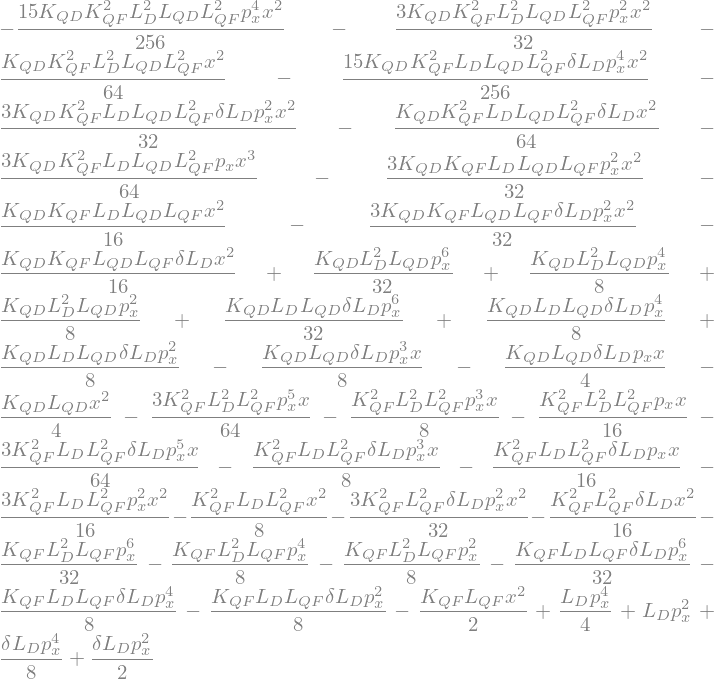

In [15]:
# project on x-px plane
Hringxpx = Hring.subs(xpx_rep)
Hringxpx

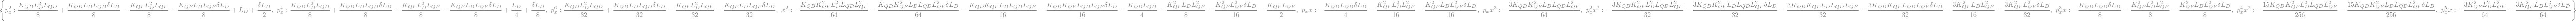

In [16]:
# coeff dict
codict(Hringxpx, x,px)

In [361]:
R = RotationMatrix2D(2*pi/4)
u,v = geteigenvects(R,symbols=[x,y])
pol4 = getpoly(u,v,symorder=4,porder=6,symbols=[x,y])
pol4 = [p.subs(y,px) for p in pol4]
pol4

Green terms are rotational invariant for any angle (powers of length).
$$
\left[ 1, \  \color{blue}{p_{x}^{4} - 6 p_{x}^{2} x^{2}} + \color{red}{x^{4}}, 
\  \color{blue}{4 p_{x}^{3} x - 4 p_{x} x^{3}}, \  \color{green}{p_{x}^{2} + x^{2}}, \  \color{green}{p_{x}^{4} + 2 p_{x}^{2} x^{2}} + \color{red}{x^{4}}, \  \color{blue}{p_{x}^{2} x^{2}}\right]
$$

Notice we do not have $x^4$ term - but can be achieved with BCH for example through:
$$\lbrace x^{2},\lbrace x^{2},\lbrace x^{2}, \lbrace x^{2}, p_{x}^{4} \rbrace  \rbrace  \rbrace  \rbrace = 384 x^{4}
$$

In [118]:
rep = list(zip(
    [
        LD,
        LD2,
        LQF,
        LQD,
        KQF,
        KQD,
        delta,
        dld
    ],
    [
        3.5805,
        3.5805,
        0.342,
        0.668,
        0.49,
        -0.4999,
        1.5e-3,
        1
    ]
)
          )


In [119]:
# Ringham but step for step to analyze the steps
beamline = [
    [eldict['quad'] , 2, LQF, KQF, thin],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 2, LQD, KQD, thin],
    [eldict['drift'], 4, LD,   Zero(), 0   ],
    [eldict['quad'] , 2, LQF, KQF, thin],
]
bchorder=4
element = beamline[0]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(rep)
H_int2 = LieOperator(H0,[x,y,z],[px,py,delta]).doit()

element = beamline[1]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(rep)
H0 = LieOperator(H0,[x,y,z],[px,py,delta])
H_int2 = H_int2.BCH(H0,bchorder).doit()

element = beamline[2]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(rep)
H0 = LieOperator(H0,[x,y,z],[px,py,delta])
H_int2 = H_int2.BCH(H0,bchorder).doit()

In [140]:
# next element
element = beamline[3]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(rep)
H0 = LieOperator(H0,[x,y,z],[px,py,delta])
H_int2 = H_int2.BCH(H0,3).doit()

In [141]:
cd = codict(H_int2.ham.subs(xpx_rep).expand(),x,px)

In [142]:
cd

<IPython.core.display.Javascript object>


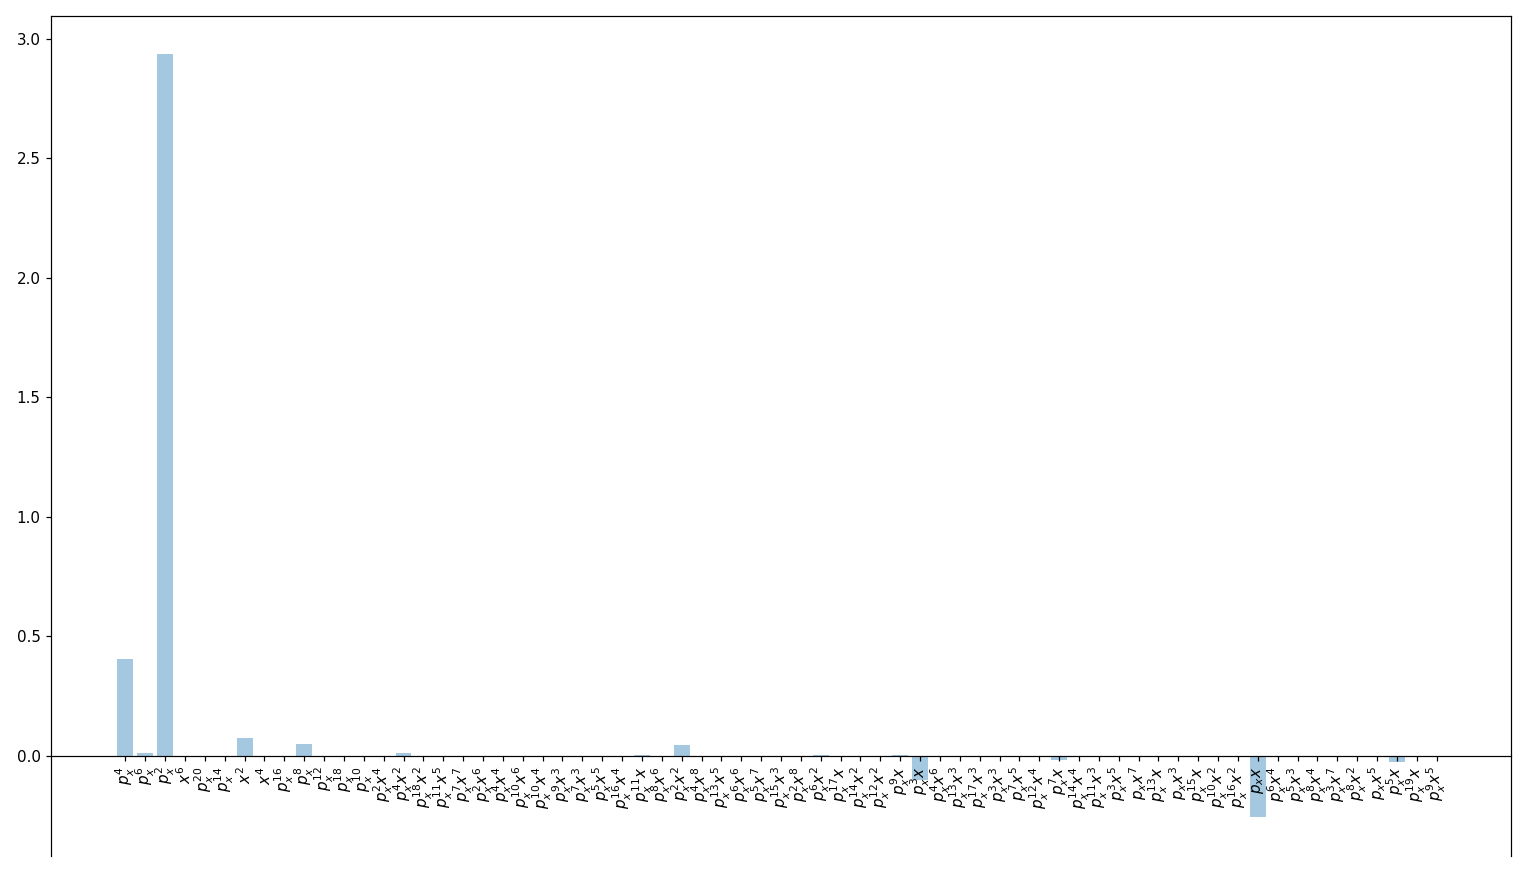

In [150]:
fig= plt.figure(figsize=(14,8))
plt.bar(range(len(cd)), list(cd.values()), align='center', alpha=.4)
ax= plt.gca()
ax.spines['bottom'].set_position('zero')
plt.xticks(range(len(cd)), list([r"${}$".format(latex(k)) for k in cd.keys()]), rotation=90)
plt.tight_layout()

In [470]:
# Ringham but step for step to analyze the steps
beamline = [
    [eldict['quad'] , 4, LQF, KQF, thin],
    [eldict['drift'], 6, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQD, KQD, thin],
    [eldict['drift'], 6, LD,   Zero(), 0   ],
    [eldict['quad'] , 4, LQF, KQF, thin],
]

bchorder=4
torder = 10

element = beamline[0]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H_int2 = LieOperator(H0,[x],[px]).doit()
H_int2 = truncate(H_int2,torder)
H_int2 = LieOperator(H_int2,[x],[px]).doit()

element = beamline[1]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int2 = H_int2.BCH(H0,bchorder).doit()
H_int2 = truncate(H_int2,torder)
H_int2 = LieOperator(H_int2,[x],[px]).doit()

In [471]:
element = beamline[2]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int2 = H_int2.BCH(H0,bchorder).doit()
H_int2 = truncate(H_int2,torder)
H_int2 = LieOperator(H_int2,[x],[px]).doit()

In [473]:
element = beamline[3]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int2 = H_int2.BCH(H0,bchorder).doit()
H_int2 = truncate(H_int2,torder)
H_int2 = LieOperator(H_int2,[x],[px]).doit()

In [475]:
element = beamline[4]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int2 = H_int2.BCH(H0,bchorder).doit()
H_int2 = truncate(H_int2,torder)
H_int2 = LieOperator(H_int2,[x],[px]).doit()

In [302]:
cd2 = codict(H_int2.ham,x,px)

<IPython.core.display.Javascript object>


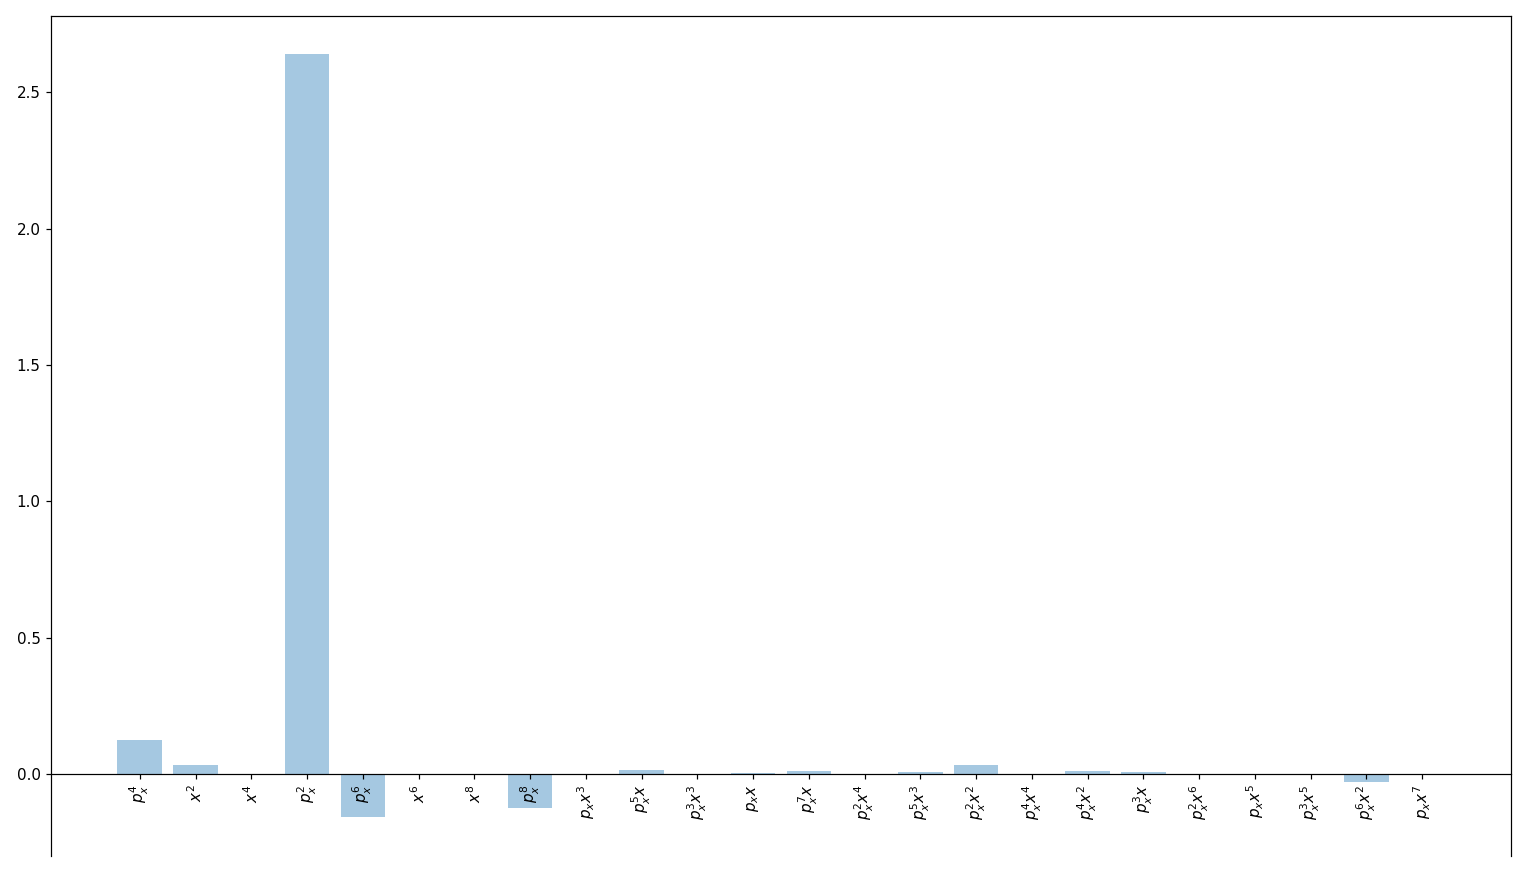

In [476]:
cd2 = codict(H_int2.ham,x,px)
fig= plt.figure(figsize=(14,8))
plt.bar(range(len(cd2)), list(cd2.values()), align='center', alpha=.4)
ax= plt.gca()
ax.spines['bottom'].set_position('zero')
plt.xticks(range(len(cd2)), list([r"${}$".format(latex(k)) for k in cd2.keys()]), rotation=90)
plt.tight_layout()

In [477]:
cd2[px**2]

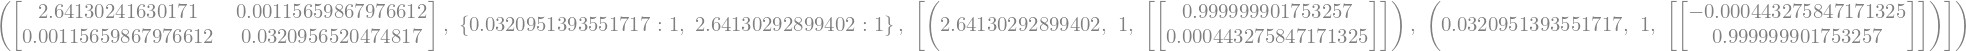

In [478]:
A = Matrix([[cd2[px**2],cd2[x*px]/2.],[cd2[x*px]/2., cd2[x**2]]])
A, A.eigenvals(), A.eigenvects()

In [479]:
from sympy import transpose

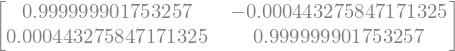

In [480]:
PT = Matrix([transpose(A.eigenvects()[0][2][0]),transpose(A.eigenvects()[1][2][0])])
PT.T

In [481]:
tr = PT * Matrix( [ x, px ] ) 
elrep = list(zip([x,px],[tr[0],tr[1]]))

In [482]:
A.eigenvals()

In [483]:
eigv2

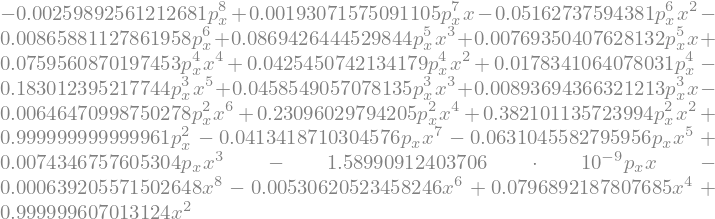

In [484]:
eigv1 = A.eigenvects()[0][0]
eigv2 = A.eigenvects()[1][0]
new_h = H_int2.ham.subs(elrep).expand().subs(list(zip([x,px],[x/sqrt(eigv2),px/sqrt(eigv1)])))
new_h

In [485]:
cd3 = codict(new_h,x,px)

<IPython.core.display.Javascript object>


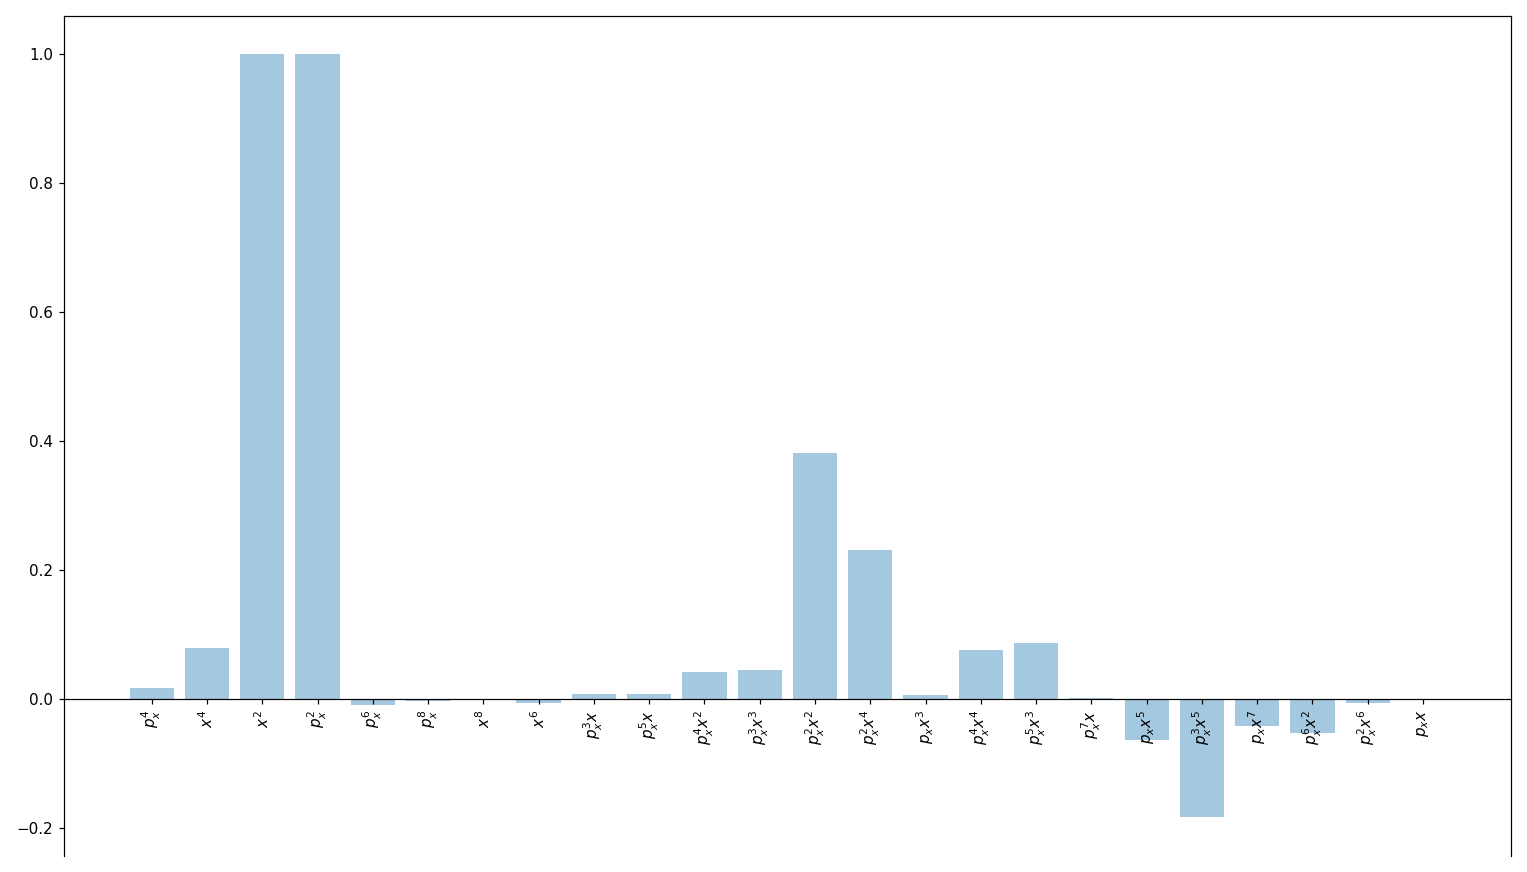

In [486]:
fig= plt.figure(figsize=(14,8))
plt.bar(range(len(cd3)), list(cd3.values()), align='center', alpha=.4)
ax= plt.gca()
ax.spines['bottom'].set_position('zero')
plt.xticks(range(len(cd3)), list([r"${}$".format(latex(k)) for k in cd3.keys()]), rotation=90)
plt.tight_layout()

In [469]:
cd3[px*x**3]

<IPython.core.display.Javascript object>


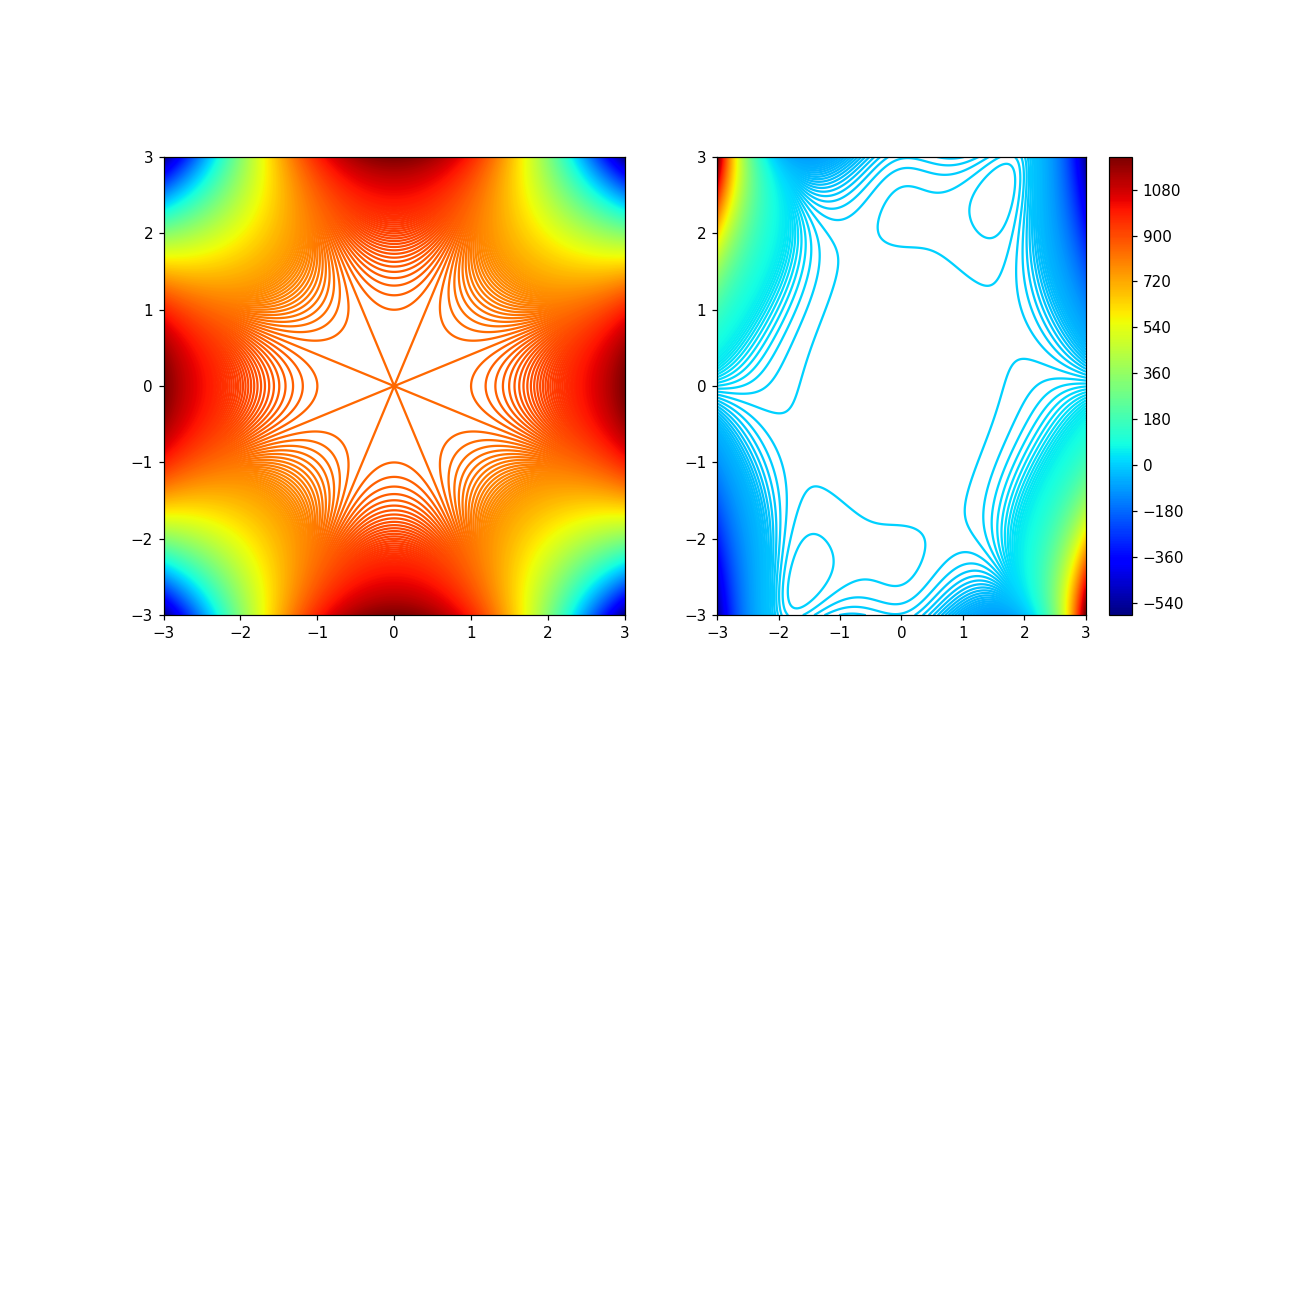

<ipython-input-547-70d71f1e71ac>:41: UserWarning: The following kwargs were not used by contour: 'linewidth'
  axes[0].contour(Xg, Pg, Hlist, levels=450,cmap=cm.jet, linewidth=.1)
<ipython-input-547-70d71f1e71ac>:46: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cb = axes[1].contour(Xg, Pg, Hlist, levels=450,cmap=cm.jet, linewidth=.1) #np.arange(4.3,5.5,0.05)


In [547]:
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(2, 2)
axes = [fig.add_subplot(gs[i, j]) for j in range(2) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 3
prange = 3
npoints= 800
X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

# func = lambdify((x,px), 0.5*(-x**3*px+x*px**3) + (x**2-px**2)**2 + (x**2+px**2), 'numpy')
# func = lambdify((x,px), px**4 - 1.5* x**2 * px**2  + x**4 -  (x**2+px**2), 'numpy')
# func = lambdify((x,px), (-x**3*px+x*px**3) - (x**2+px**2) + 0.35*(x**2+px**2)**2 , 'numpy') # skew oct
# func = lambdify((x,px), (-x**3*px + x*px**3) -(x**2+px**2) + 0.3*(x**2+px**2)**2, 'numpy')
# func = lambdify((x,px), x**2*px**2 - (x**2+px**2) + 0.1*(x**2+px**2)**2, 'numpy')
# func = lambdify((x,px), 0.5*(-x**3*px + x*px**3) + x**2*px**2 - (x**2+px**2) + 0.2*(x**2+px**2)**2, 'numpy') # add skew oct
# func = lambda x,px: px**4 + x**2 + px**2

func1 = cd3[x**2*px**2]*x**2*px**2
func2 = cd3[x**4]*x**4
func3 = cd3[px**4]*px**4
func4 = cd3[px**3*x]*px**3*x
func5 = cd3[x**3*px]*x**3*px

func6 = cd3[px*x**5]*x**5*px
func7 = cd3[x*px**5]*px**5*x

func8 = cd3[x**2*px**4]*x**2*px**4

func9 = cd3[x**3*px**3]*x**3*px**3

func10 = cd3[x**6]*x**6
funclin = cd3[x**2]*x**2 + cd3[px**2]*px**2

func = lambdify((x,px), x**4-6*x**2*px**2+px**4  ,'numpy')
# func = lambdify((x,px), new_h - 0.2*x**2 * px **2 ,'numpy')
Hlist = func(Xg, Pg) 
# axes[0].plot_surface(Xg, Pg, Hlist, rstride=50,alpha=.4)
axes[0].contour(Xg, Pg, Hlist, levels=450,cmap=cm.jet, linewidth=.1)

func = lambdify((x,px), new_h - 0.2*x**2 * px **2 ,'numpy')
func = lambdify((x,px), new_h + 0.1*( x**4-6*x**2*px**2+px**4) ,'numpy')
Hlist = func(Xg, Pg) 
cb = axes[1].contour(Xg, Pg, Hlist, levels=450,cmap=cm.jet, linewidth=.1) #np.arange(4.3,5.5,0.05)
plt.colorbar(cb)

<IPython.core.display.Javascript object>


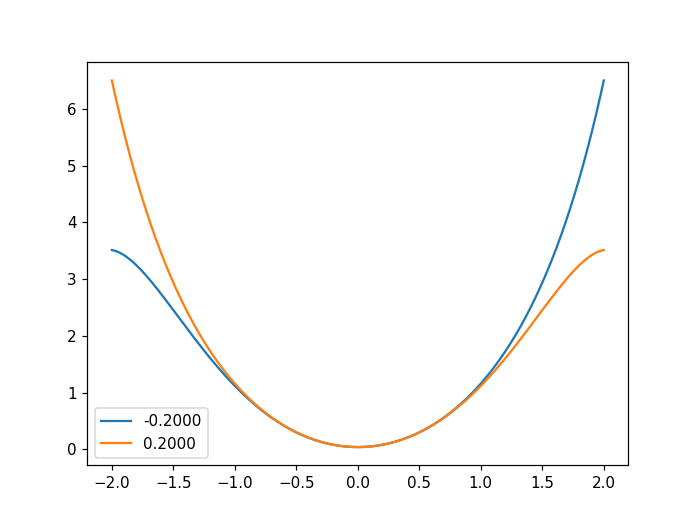

In [490]:
Hring_num = lambdify((x,px),new_h,'numpy')
plt.figure()
X = np.linspace(-2,2,1000)
for p in np.linspace(-0.2,.2,2):
    plt.plot(X, Hring_num(X,p),label="{:.4f}".format(p))
plt.legend()

<IPython.core.display.Javascript object>


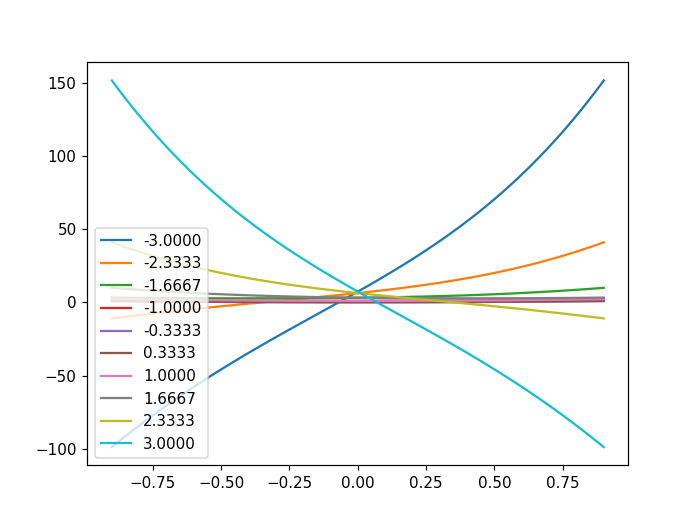

In [491]:
plt.figure()
P = np.linspace(-0.9,.9,100)
for xx in np.linspace(-3,3,10):
    plt.plot(P, Hring_num(xx,P),label="{:.4f}".format(xx))
plt.legend(loc=3)

<IPython.core.display.Javascript object>


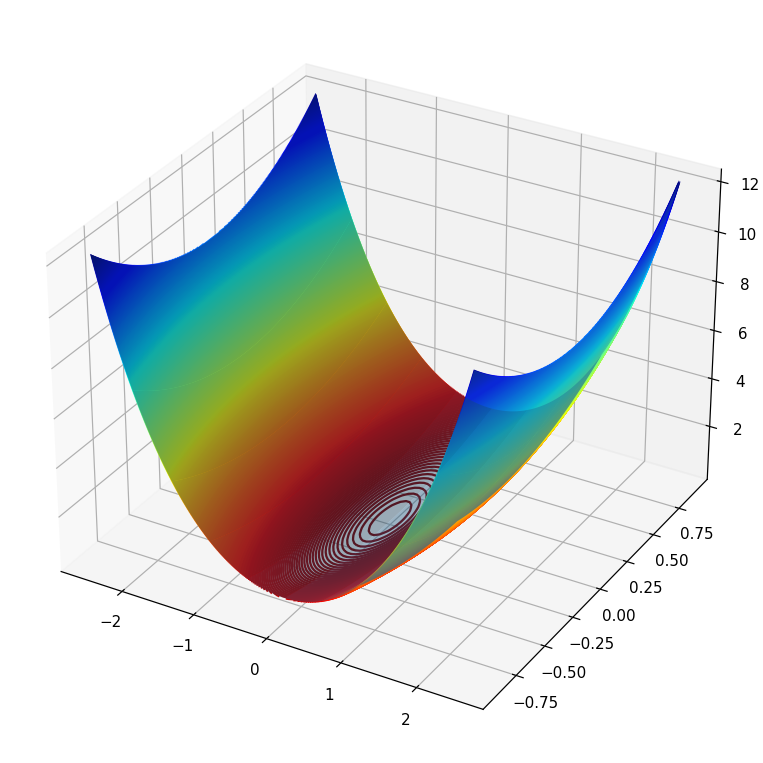

In [270]:
func = lambdify((x,px),H_int2.ham-2.65*px**2,'numpy')
func = lambdify((x,px),new_h,'numpy')

multi_countour_plot(
    [func], 
    titlelist=["$1^e$ order","$2^e$ order","$3^e$ order","$4^e$ order"],
    xlabels=[r"$x$"]*4,
    ylabels=[r"$p_x$"]*4,
    xrange=2.5,
    prange=.9,
    nlevels=500,
    size = (7,7),
    d3=True
    
)

In [ ]:


# element = beamline[3]
# H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
# H0 = LieOperator(H0,[x,y,z],[px,py,delta])
# H_int2 = H_int2.BCH(H0,bchorder).doit()

In [ ]:
# redefine for use in ringham - otherwise assumption errors
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")
dld   = symbols('\delta{L_D}') # delta length drift

rep = list(zip(
    [
        LD,
        LD2,
        LQF,
        LQD,
        KQF,
        KQD,
        delta,
        dld
    ],
    [
        3.5805,
        3.5805,
        0.342,
        0.668,
        0.49,
        -0.4999,
        1.5e-3,
        1
    ]
)
          )
